In [1]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback


In [19]:
# Principal covariance regression

In [20]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'data', '189228-expt.json')
final_state_expt_file = os.path.join(git_dir, 'data', '189237-expt.json')

data_file = os.path.join(git_dir, 'data', 'r189236-time-resolved.json')

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'])
    _data = m['data']
    print("Number of times: %s" % len(_data))
    

REVERSE = True
MIXING = True

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data, reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()



Number of times: 25
0


<IPython.core.display.Javascript object>


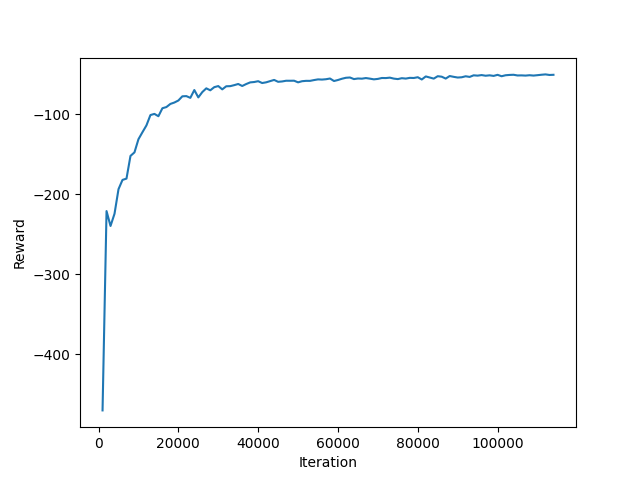

In [21]:
log_dir = "./logs-01-to-06-mixing-bck/"
log_dir = "./logs-01-to-06-mixing-bck-end-free-2/"
log_dir = "./logs-01-to-06-mixing-bck-2ends-free-3/"
#log_dir = "./logs-01-to-06-1st-mixing-fwd/"

_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    time_chi2 = []
    
    for i in range(n_times):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
        time_chi2.append(reward)

    return episode_reward, time_chi2

itr_list = []
reward_list = []
time_chi2_list = []
models = []

for file in _dir_list:
    try:
        model = SAC.load(os.path.join(log_dir, file))
        reward, time_chi2 = evaluate(model)
        iteration = int(file.replace("rl_model_", "").replace("_steps.zip", ""))
        itr_list.append(iteration)
        reward_list.append(reward)
        time_chi2_list.append(time_chi2)
        models.append(model)
    except:
        print("skip: %s" % file)

time_chi2_list = np.asarray(time_chi2_list)
itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

(114, 25)
114000


<IPython.core.display.Javascript object>


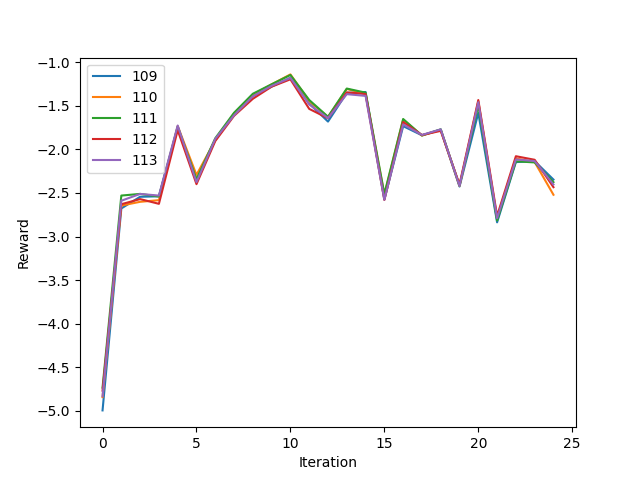

In [22]:
print(time_chi2_list.shape)
print(itr_list[idx][-1])

fig = plt.figure(dpi=100)

for i in range(len(time_chi2_list)-5, len(time_chi2_list)):   
    plt.plot(np.arange(time_chi2_list.shape[1]), time_chi2_list[idx][i], label=str(i))
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [23]:
# Evaluate the agent
#Nature catalyssiis 2 1055 2019

model = models[idx[-1]]
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 25
Time 1440 [1.]: -4.83139 [False] -4.83139
Time 1380 [0.9583333]: -2.58937 [False] -7.42077
Time 1320 [0.9166667]: -2.51143 [False] -9.93219
Time 1260 [0.875]: -2.53037 [False] -12.4626
Time 1200 [0.8333333]: -1.72687 [False] -14.1894
Time 1140 [0.7916667]: -2.37572 [False] -16.5652
Time 1080 [0.75]: -1.88009 [False] -18.4452
Time 1020 [0.7083333]: -1.60909 [False] -20.0543
Time 960 [0.6666667]: -1.39213 [False] -21.4465
Time 900 [0.625]: -1.27181 [False] -22.7183
Time 840 [0.5833333]: -1.18152 [False] -23.8998
Time 780 [0.5416667]: -1.48559 [False] -25.3854
Time 720 [0.5]: -1.64185 [False] -27.0272
Time 660 [0.45833334]: -1.36727 [False] -28.3945
Time 600 [0.41666666]: -1.38737 [False] -29.7819
Time 540 [0.375]: -2.57786 [False] -32.3597
Time 480 [0.33333334]: -1.71379 [False] -34.0735
Time 420 [0.29166666]: -1.83509 [False] -35.9086
Time 360 [0.25]: -1.77107 [False] -37.6797
Time 300 [0.20833333]: -2.41934 [False] -40.099
Time 240 [0.16666667]: -1.45869 [False] -41

In [24]:
deltas = env.high_array - env.low_array

samples = []
mixing = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)

    if MIXING:
        mixing.append((1+actions[:,-1]) / 2.0)


samples = np.asarray(samples).T
mixing = np.asarray(mixing).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

if MIXING:
    mixing_err = np.std(mixing, axis=1)
    print(mixing_err.shape)

(3, 25, 100)
(3, 25)
(25,)


<IPython.core.display.Javascript object>


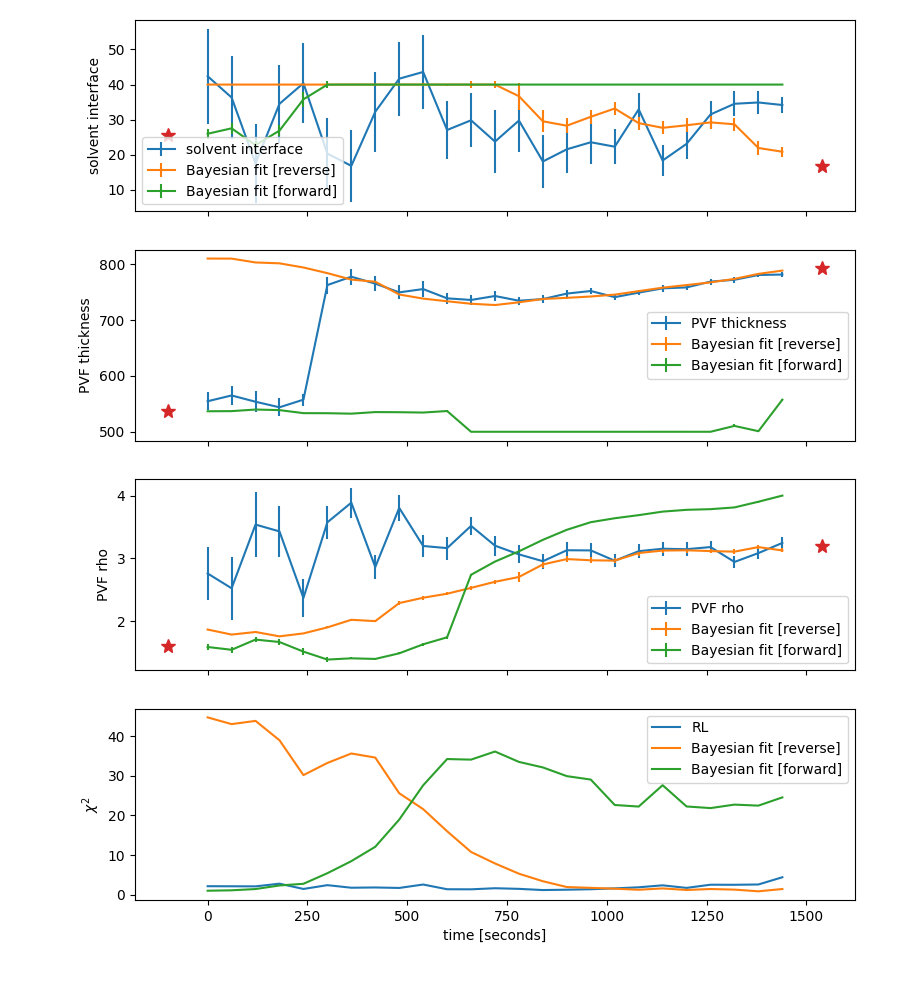

['solvent interface', 'PVF thickness', 'PVF rho']
[   0   60  120  180  240  300  360  420  480  540  600  660  720  780
  840  900  960 1020 1080 1140 1200 1260 1320 1380 1440]


Text(0.5, 0, 'time [seconds]')

In [25]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T

# Bayesian fit trend
with open(os.path.join(git_dir, 'data', '189236-bayes-forward.json')) as fd:
    bayes_fits_fwd = json.load(fd)
with open(os.path.join(git_dir, 'data', '189236-bayes-backward.json')) as fd:
    bayes_fits = json.load(fd)

t_delay = 100
if REVERSE:
    t_start = times[0]+t_delay
    t_end = -t_delay
else:
    t_end = times[-1]+t_delay
    t_start = -t_delay

n_times = len(env.data)

fig, axs = plt.subplots(4,1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(4, 1, i+1)
    
    plt.errorbar(times, pars[i], yerr=errs[i], label=env.par_labels[i])

    label = env.par_labels[i].lower().replace(" ", "_")
    if label in bayes_fits:
        values = bayes_fits[label]
        d_values = bayes_fits[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [reverse]')

    if label in bayes_fits_fwd:
        values = bayes_fits_fwd[label]
        d_values = bayes_fits_fwd[label+'_err']
        plt.errorbar(timestamps, values, yerr=d_values, label='Bayesian fit [forward]')
    
    #plt.plot([t_start], [env.parameters[i]], linestyle='', marker='*', markersize=10)
    plt.plot([t_start, t_end], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(4, 1, i+1)
plt.plot(times, chi2, label = 'RL')
print(timestamps)
plt.plot(timestamps, bayes_fits['chi2'], label = 'Bayesian fit [reverse]')
plt.plot(timestamps, bayes_fits_fwd['chi2'], label = 'Bayesian fit [forward]')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 25


<IPython.core.display.Javascript object>


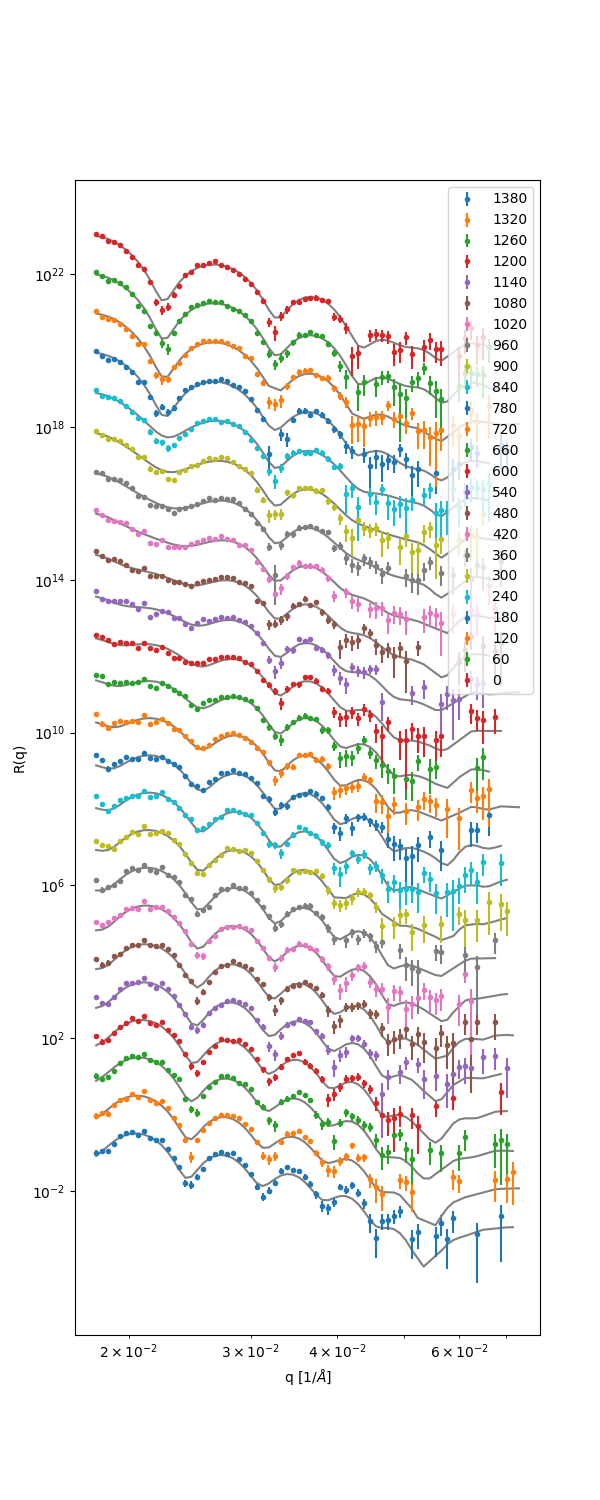

In [26]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=times[i])


<IPython.core.display.Javascript object>


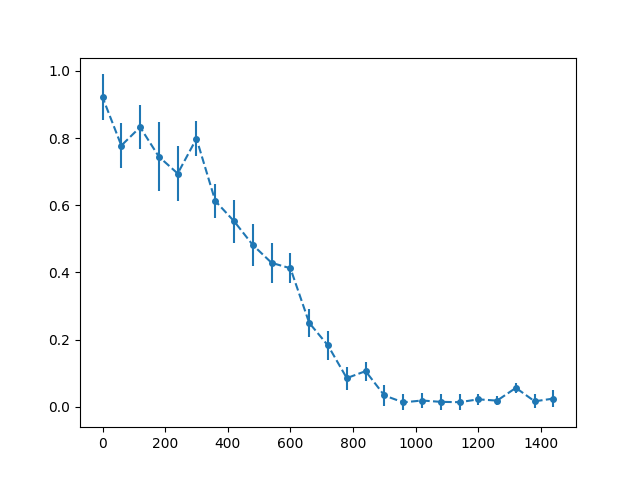

<ErrorbarContainer object of 3 artists>

In [27]:
actions = np.asarray(actions)
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0


mixing = (actions[:,-1] + 1)/2.0


fig = plt.subplots(dpi=100, )

plt.errorbar(times, mixing, yerr=mixing_err, label='Bayesian fit [forward]', marker='.', markersize=8, linestyle='--')
 
